# Multi Layered Perceptron Approach

In [ ]:
# Mounting drive and importing dataset from google drive

from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Unzipping all the npy files, which creates a new folder (/data) in the root directory.
!tar -xvzf /content/gdrive/MyDrive/DeepRegression/data.tgz

Streaming output truncated to the last 5000 lines.
data/image_140466812021761890849935117392024097947.npy
data/image_214454232775476126858435938728675756697.npy
data/image_130801378814327756070396393793485679451.npy
data/image_311893850764781353709529115536192378408.npy
data/image_282165301331939040711285061265397272591.npy
data/image_21440908318479958144560759949570839926.npy
data/image_14246263583378039485404972992679267669.npy
data/image_14159338952001522610968069444327016917.npy
data/image_136653021479910190046378102527256138307.npy
data/image_332932571917593010534093958031892783820.npy
data/image_270111698154078866315002421949443996447.npy
data/image_141276881797963724247841965871917381705.npy
data/image_189348898416623356872431659680862005654.npy
data/image_2066840381301645643610836490276655881.npy
data/image_309460885844656250230861071645143094921.npy
data/image_258134283852911782251417926629741928725.npy
data/image_178762768427299605340851784625807099718.npy
data/image_30301588

In [ ]:
# Installing a previous version of numpy as it is not supporting the extraction of all the npy files at once.
!pip install numpy==1.16.1

# Please restart the runtime, and then proceed from this cell onwards.

     |████████████████████████████████| 17.3MB 209kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.16.1 which is incompatible.
ERROR: pyarrow 3.0.0 has requirement numpy>=1.16.6, but you'll have numpy 1.16.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.2 has requirement numpy>=1.17, but you'll have numpy 1.16.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [1]:
# Declaring all imports
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import pandas as pd
import torchvision
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

## Loading & Visualizing the data

In [2]:
# Extracting all the npy files from the folder
numpy_vars = []
for np_name in glob.glob('/content/data/*.np[yz]'):
    numpy_vars.append(np.load(np_name))

In [3]:
# Understanding the shape of the dataset
print(numpy_vars[0].shape)
print(numpy_vars[0])

(2,)
[array([[31, 38, 26, ..., 27, 26, 32],
       [31, 33, 33, ..., 28, 37, 31],
       [32, 23, 28, ..., 40, 31, 38],
       ...,
       [23, 24, 38, ..., 34, 34, 35],
       [28, 30, 31, ..., 34, 23, 20],
       [34, 29, 22, ..., 34, 29, 31]])
 251.35706748570095]


251.35706748570095


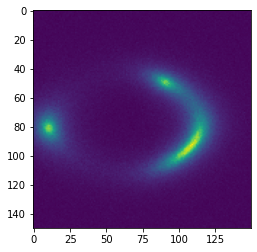

In [4]:
# Let us visualize the dataset
plt.imshow(numpy_vars[0][0])
print(numpy_vars[0][1])

In [5]:
# Flattening all the inputs to 1D arrays
for i in range(len(numpy_vars)):
  numpy_vars[i][0] = numpy_vars[i][0].flatten()

In [6]:
# Loading data into pandas
dataset = pd.DataFrame(numpy_vars)

In [7]:
# Visualizing the dataset
dataset

,0,1
0,"[31, 38, 26, 21, 31, 33, 32, 35, 30, 26, 32, 3...",251.357067
1,"[29, 32, 26, 35, 26, 31, 24, 31, 30, 25, 35, 3...",202.204284
2,"[31, 28, 32, 32, 29, 34, 30, 28, 33, 41, 23, 3...",178.576253
3,"[27, 26, 30, 31, 38, 27, 29, 30, 29, 40, 25, 2...",189.114355
4,"[35, 25, 32, 32, 33, 31, 34, 24, 29, 24, 28, 3...",348.129710
...,...,...
24995,"[28, 29, 21, 36, 37, 37, 34, 27, 42, 27, 22, 2...",256.138863
24996,"[33, 21, 28, 27, 29, 27, 28, 34, 20, 35, 38, 2...",173.018592
24997,"[36, 28, 35, 30, 32, 27, 38, 30, 34, 28, 28, 2...",86.041999
24998,"[31, 33, 36, 36, 37, 20, 32, 30, 32, 28, 27, 3...",323.069231


In [8]:
# Separating image dataset and label dataset
image_dataset = dataset[0].values
label_dataset = dataset[1].values

(array([1.8841e+04, 1.8200e+03, 7.9500e+02, 4.3900e+02, 2.3400e+02,
        1.4200e+02, 9.9000e+01, 7.2000e+01, 4.7000e+01, 1.1000e+01]),
 array([ 14. , 101.8, 189.6, 277.4, 365.2, 453. , 540.8, 628.6, 716.4,
        804.2, 892. ]),
 <a list of 10 Patch objects>)

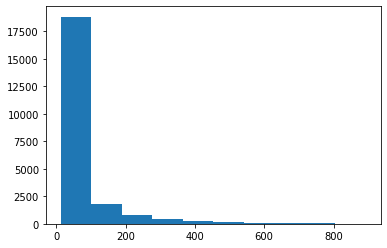

In [9]:
plt.hist(image_dataset[0])
# Here we can see that the values are having a huge range of values crossing 255

In [10]:
# Rescaling the images to 0-255
for i in range(len(image_dataset)):
  image_dataset[i] = image_dataset[i]/np.amax(image_dataset[i]) * 255

(array([1.8841e+04, 1.8200e+03, 7.9500e+02, 4.3900e+02, 2.3400e+02,
        1.4200e+02, 9.9000e+01, 7.2000e+01, 4.7000e+01, 1.1000e+01]),
 array([  4.00224215,  29.10201794,  54.20179372,  79.30156951,
        104.40134529, 129.50112108, 154.60089686, 179.70067265,
        204.80044843, 229.90022422, 255.        ]),
 <a list of 10 Patch objects>)

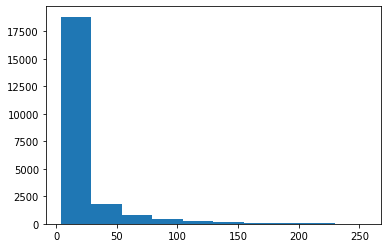

In [11]:
plt.hist(image_dataset[0])
# Rescaling the dataset

In [12]:
# Train test split of 90:10
X_train, X_test, Y_train, Y_test = train_test_split(image_dataset, label_dataset, test_size=0.1)

In [13]:
# X_train shape
print(X_train.shape)

(22500,)


In [14]:
# Y_test shape
print(Y_test.shape)

(2500,)


## Preparing the Custom dataset

In [33]:
class CustomDataset(Dataset):
    def __init__(self, X_train, Y_train, X_test, Y_test, phase):
        self.dataset = dataset
        self.phase = phase
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = torch.from_numpy(Y_test).type(torch.LongTensor)
        self.tensor_Y_train = torch.from_numpy(Y_train).type(torch.LongTensor)

    def __getitem__(self, idx):
        if self.phase == 'train':

            trainsample = self.X_train[idx]
            
            data = torch.from_numpy(trainsample).type(torch.LongTensor)
            label = self.tensor_Y_train[idx]
            return data, label

        elif self.phase == 'test':
            
            testsample = self.X_test[idx]

            data = torch.from_numpy(testsample).type(torch.LongTensor)
            label = self.Y_test[idx]
            return data, label

    def __len__(self):
        if self.phase == "train":
          return len(X_train)
        else:
          return len(X_test)

In [34]:
training_data = CustomDataset(X_train, Y_train, X_test, Y_test, 'train')
testing_data = CustomDataset(X_train, Y_train, X_test, Y_test, 'test')

In [35]:
train_loader = DataLoader(training_data, batch_size=10, shuffle=True)
test_loader = DataLoader(testing_data, batch_size = 10, shuffle=False)

In [18]:
del numpy_vars # Deleting unused variables to save ram

In [19]:
batch_size = 10

## Initializing the Model

In [20]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(22500,10000)
        self.linear2 = nn.Linear(10000,5000)
        self.linear3 = nn.Linear(5000,1000)
        self.linear4 = nn.Linear(1000,100)
        self.linear5 = nn.Linear(100,1)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.relu(self.linear3(X))
        X = F.relu(self.linear4(X))
        X = self.linear5(X)
        return X
 
mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=22500, out_features=10000, bias=True)
  (linear2): Linear(in_features=10000, out_features=5000, bias=True)
  (linear3): Linear(in_features=5000, out_features=1000, bias=True)
  (linear4): Linear(in_features=1000, out_features=100, bias=True)
  (linear5): Linear(in_features=100, out_features=1, bias=True)
)


In [21]:
# Loading the model onto the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mlp.to(device)

cuda:0


MLP(
  (linear1): Linear(in_features=22500, out_features=10000, bias=True)
  (linear2): Linear(in_features=10000, out_features=5000, bias=True)
  (linear3): Linear(in_features=5000, out_features=1000, bias=True)
  (linear4): Linear(in_features=1000, out_features=100, bias=True)
  (linear5): Linear(in_features=100, out_features=1, bias=True)
)

In [22]:
# Defining the train function
def train(model, train_loader):

    loss_plot = []
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))#,lr=0.001, betas=(0.9,0.999))
    error = nn.MSELoss()
    EPOCHS = 30 
    epoch_loss = 0

    model.train()
    for epoch in range(EPOCHS):
        running_mse = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float().to(device)
            var_y_batch = Variable(torch.reshape(y_batch, (batch_size, 1))).float().to(device)
            optimizer.zero_grad()
            output = model(var_X_batch)

            loss = error(output, var_y_batch)
            running_mse += loss.item() * batch_size

            loss.backward()
            optimizer.step()

            # if batch_idx % 50 == 0:
                # print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t'.format(epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data))
        
        
        epoch_loss = running_mse / len(train_loader.dataset)
        print('Epoch : {} \t MSELoss: {:.6f}\t'.format(epoch, epoch_loss))
        loss_plot.append(running_mse)
    plt.plot(loss_plot)

            

Epoch : 0 	 MSELoss: 31235.197149	
Epoch : 1 	 MSELoss: 134.642042	
Epoch : 2 	 MSELoss: 95.335755	
Epoch : 3 	 MSELoss: 89.674276	
Epoch : 4 	 MSELoss: 73.121333	
Epoch : 5 	 MSELoss: 71.390738	
Epoch : 6 	 MSELoss: 63.940184	
Epoch : 7 	 MSELoss: 63.258784	
Epoch : 8 	 MSELoss: 57.076363	
Epoch : 9 	 MSELoss: 55.554229	
Epoch : 10 	 MSELoss: 53.116682	
Epoch : 11 	 MSELoss: 56.653433	
Epoch : 12 	 MSELoss: 48.913332	
Epoch : 13 	 MSELoss: 50.527184	
Epoch : 14 	 MSELoss: 51.667966	
Epoch : 15 	 MSELoss: 49.239239	
Epoch : 16 	 MSELoss: 47.631698	
Epoch : 17 	 MSELoss: 45.969069	
Epoch : 18 	 MSELoss: 43.841243	
Epoch : 19 	 MSELoss: 46.449886	
Epoch : 20 	 MSELoss: 43.596978	
Epoch : 21 	 MSELoss: 44.455530	
Epoch : 22 	 MSELoss: 43.389206	
Epoch : 23 	 MSELoss: 39.621385	
Epoch : 24 	 MSELoss: 42.252291	
Epoch : 25 	 MSELoss: 40.709409	
Epoch : 26 	 MSELoss: 39.292593	
Epoch : 27 	 MSELoss: 38.166274	
Epoch : 28 	 MSELoss: 37.951121	
Epoch : 29 	 MSELoss: 39.208425	


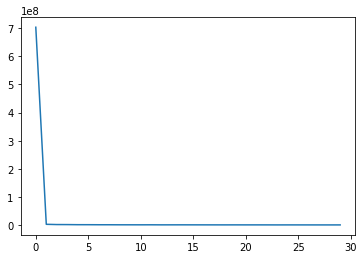

In [23]:
train(mlp, train_loader)

In [24]:
torch.save(mlp.state_dict(), '/content/mlp.pth')

In [26]:
!cp /content/mlp.pth /content/gdrive/MyDrive/DeepRegression/

In [37]:
# Evaluating the model
def evaluate(model):

  running_mse = 0
  loss = nn.MSELoss()
  eval = 0
  for test_imgs, test_labels in test_loader:
      
      test_imgs = Variable(test_imgs).float().to(device)
      test_labels = Variable(torch.reshape(test_labels, (batch_size, 1))).float().to(device)

      output = model(test_imgs)
      
      loss_data = loss(output, test_labels)
      running_mse += loss_data.item() * batch_size



  eval = running_mse / len(test_loader.dataset)
  print("MSE Loss: {:.3f} ".format(eval))


In [38]:
evaluate(mlp)

MSE Loss: 38.325 


# References

1. [Regression With Neural Networks in Pytorch](https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379)

2. [Pytorch Regression](https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93)

3. [Regression Analysis](https://www.analyticsvidhya.com/blog/2020/10/perform-regression-analysis-with-pytorch-seamlessly/)

4. [Neural Regression](https://visualstudiomagazine.com/articles/2021/02/11/pytorch-define.aspx)
